<a href="https://colab.research.google.com/github/SSInimgba/Face-Detection/blob/main/Face_Detection_and_Count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How many faces?

You are provided with images of people at meetings, gatherings, group photos, etc. Count the number of faces you can spot in each image. There will be no more than 15 faces in each of the images. Assume that half or more of each face will be visible.

**TASKS**
 

- Create a GitHub repository for your solution to the above problem.

- Discuss in detail how you solved the problem.
- Are there other ways the problem could be solved? Discuss briefly


In [10]:
!pip install mtcnn -q

In [3]:
import numpy as np
from pathlib import Path
import cv2
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [4]:
# Get the path of the txt files
image_1_path = '/content/drive/MyDrive/NB/input/input00.txt'
image_2_path = '/content/drive/MyDrive/NB/input/input01.txt'
image_3_path = '/content/drive/MyDrive/NB/input/input02.txt'

image_path_list = [image_1_path, image_2_path, image_3_path]

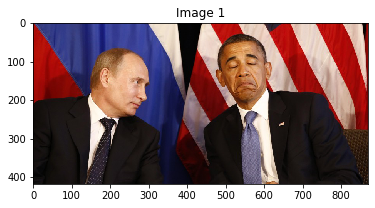

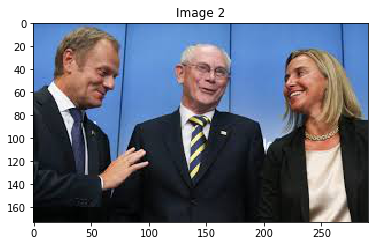

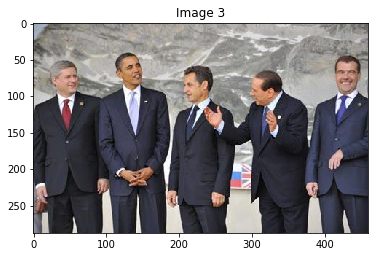

In [5]:
images = []
dataset = []
CHANNEL = 3

for i, image_path in enumerate(image_path_list):
  with open(image_path, "r") as file: # read the data from the text file
    lines = file.readlines()
    image_list = [[line.replace(" ", ",").split(",")] for line in lines[1:]]
    images.append(image_list) # create a list of list of the images
  first_line = lines[0]
  first_line = first_line.split()
  R = int(first_line[0]) # rows
  C = int(first_line[1]) # columns
  image = np.array(images[i])
  image = image.reshape(R, C, CHANNEL).astype(np.uint8) 
  image = image[:,:,::-1] # transform to RGB
  dataset.append(image) # create a list of the transformed images
  plt.imshow(image, interpolation='nearest')
  plt.title(f'Image {i+1}')
  plt.show()

# METHOD 1: Face Detection with OpenCV

### Face Detection using Haar Cascades from  OpenCV. 


This is dependent on a technique called **Classifier Cascade**, which consists of AdaBoosting algorithms that are trained to learn a range of very simple or weak features in each face, that together provide a robust classifier.

 These models are then arranged into a heircahy of increasing complexity to form a cascade. The less complex classifiers act like a filter by operating on candidate face regions directly, while the complex classifiers operate only on those candidate regions that show the most promise as faces, therfore resulting in a very fast and effective face detection algorithm. 


The **Haar Cascade** is a pretrained model in the openCV library that implements the Classifier Cascade approach. This can be downloaded from [**here**](https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml)

In [6]:
# download the haarcascade frontal face detection model from openCV
# load the model in xml to the openCV Cascade Classifier Class
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/NB/haarcascade_frontalface_default.xml')

Next step is to apply the detectMultiScale function to the image. This function has various arguments that can be tuned for better accuracy such as:
-  Scale factor: This controls how the image is scaled (up or down) before detcteion is applied.
- minNeighbours: This controls the number of candidate rectangles that found the face. The default is 3, but this can be lowered to 1 to detect a lot more faces and will likely increase the false positives, or increase to 6 or more to require a lot more confidence before a face is detected.
- minSize: This controls the minimum possible object size. Objects smaller than that are ignored.

Playing around with this argument improved face detection accuracy

Faces Found: 2


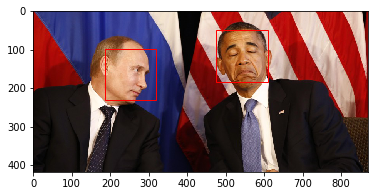

Faces Found: 1


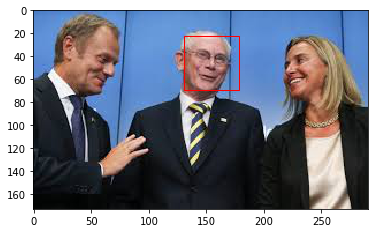

Faces Found: 2


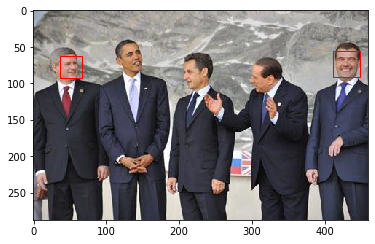

In [7]:
# convert the image to grayscale and detect faces using the detectMultiScale() function
for image in dataset:
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  haar_faces = faceCascade.detectMultiScale(gray, 
                                      scaleFactor=1.1,
                                      minNeighbors=5,
                                      minSize=(20, 20))
  print(f"Faces Found: {len(haar_faces)}")
  # Draw a rectangle around the detected faces
  for (x, y, w, h) in haar_faces:
      # Add the patch to the Axes
      ax = plt.imshow(image, interpolation='nearest')
      plt.gca().add_patch(Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none'))
  plt.show()

The haar cascade does not generalize well for all the images and only accurately detects all the images in the first image. From experimentation, we observed that each image deserves a different argument in the detectMultiScale function in order to detect the faces present in the image accurately.

If you notice the faces not detceted are mostly faces that are not aligned to the front (facing side ways). We can improve this by decreasing the minNeighbours to 3, but this results to false positives
: 


  -  Face Detection Improved
  
  ![Face Detection Improved](https://drive.google.com/uc?id=1KjKb3CFRIhai6IH6kawVHODA0Xc33McX)


  -  False positives increased

   ![False positives increased](https://drive.google.com/uc?id=1Iouyt3YnhcZOZ1P4KxGjM4gh5VdFZJOb)


# METHOD 2: Face Detection With Deep Learning (CHOSEN METHOD)

Using the **Multi-Task Cascaded Convolutional Neural Network (MTCNN)** which is popular because it achieved then state-of-the-art results on a range of benchmark datasets, and because it is capable of recognizing other facial features such as eyes and mouth, called landmark detection.

 The network uses a cascade structure with three networks; first the image is rescaled to a range of different sizes (called an image pyramid), then the first model (Proposal Network or P-Net) proposes candidate facial regions, the second model (Refine Network or R-Net) filters the bounding boxes, and the third model (Output Network or O-Net) proposes facial landmarks. 
 
 The model is called a multi-task network because each of the three models in the cascade (P-Net, R-Net and O-Net) are trained on three tasks, e.g. P-Net for face classification, R-Net for bounding box regression, and O-Net facial landmark localization. 

The outputs of the each model are fed as input to the next stage, therfore allowing additional processing to be performed between stages. For example, non-maximum suppression (NMS) is used to filter the candidate bounding boxes proposed by the first-stage P-Net prior to providing them to the second stage R-Net model. 

The implemntation of MTNCNN used for this task is by Iván de Paz Centeno.  This implementation of the MTCNN architecture uses TensorFlow and OpenCV.

In [8]:
# create the detector, using default weights
detector = MTCNN()

Faces Found: 2


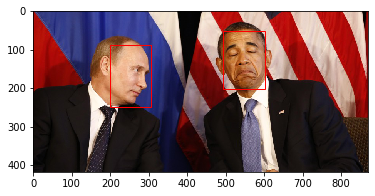

Faces Found: 3


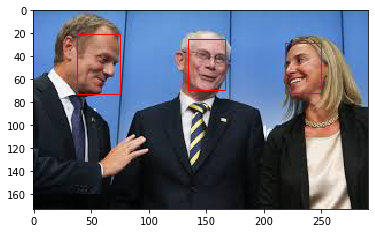

Faces Found: 5


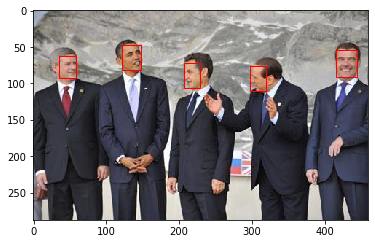

In [9]:
# Detect faces using the detect_faces() function
for image in dataset:
  mtcnn_faces = detector.detect_faces(image)
  print(f"Faces Found: {len(mtcnn_faces)}")
  # Draw a rectangle around the detected faces
  for result in mtcnn_faces:
    x, y, w, h = result['box']
    ax = plt.imshow(image, interpolation='nearest')
    # Add the patch to the Axes
    plt.gca().add_patch(Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none'))
  plt.show()

MTCNN is better and more generalizable than the Haar Cascades and needs little to no finetuning to accurately detect a face in an image regardless of facial alignment





# TASK 3:
## Are there other ways the problem could be solved? Discuss briefly